# Residual Neural Network

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

slim = tf.contrib.slim

In [0]:
tf.reset_default_graph()

# import data set

In [0]:
# (x_train, y_train), (x_test, y_test) =  tf.keras.datasets.mnist.load_data()
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train/255.0
x_train = x_train.astype(dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.int32)

x_test = x_test/255.0
x_test = x_test.astype(np.float32)
y_test = np.asarray(y_test, dtype=np.int32)

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [0]:
# #sampling
# train_data_size  = 6000
# train_idx = np.random.choice(np.arange(x_train.shape[0]), size=train_data_size, replace=False)
# # print(train_idx)
# x_train = x_train[train_idx]
# y_train = y_train[train_idx]

# train_data_size  = 2000
# test_idx = np.random.choice(np.arange(x_train.shape[0]), size=train_data_size, replace=False)
# # print(train_idx)
# x_test = x_test[test_idx]
# y_test = y_test[test_idx]

# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [0]:
labels_desc = {"Label":"Description",
0:"T-shirt/top",
1:"Trouser",
2:"Pullover",
3:"Dress",
4:"Coat",
5:"Sandal",
6:"Shirt",
7:"Sneaker",
8:"Bag",
9:"Ankle boot",}

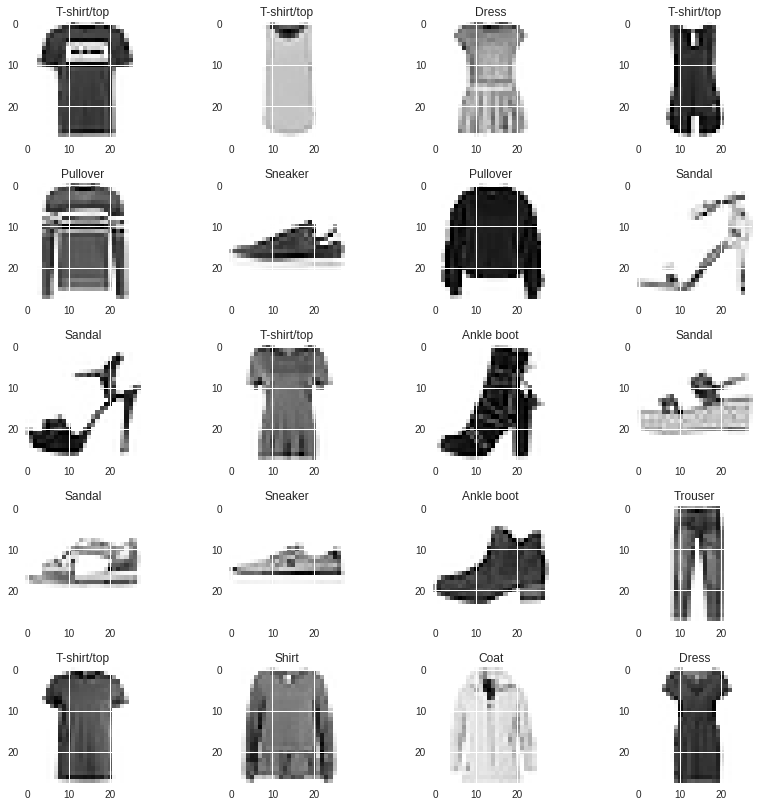

In [7]:
fig=plt.figure(figsize=(14, 14))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
#     img = np.random.randint(10, size=(h,w))
    img = x_train[i]
    fig.add_subplot(rows, columns, i)
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.title(labels_desc[y_train[i]])
    plt.imshow(img)
plt.show()

# split data

In [8]:
train_data_size  = 50000
# train_data_size  = 5000
train_idx = np.random.choice(np.arange(x_train.shape[0]), size=train_data_size, replace=False)
# print(train_idx)
x_tr = x_train[train_idx]
y_tr = y_train[train_idx]

x_val = np.delete(arr=x_train, obj=train_idx, axis=0)
y_val = np.delete(arr=y_train, obj=train_idx, axis=0)

print('train data : {}, {}'.format(x_tr.shape, y_tr.shape))
print('val data : {}, {}'.format(x_val.shape, y_val.shape))

train data : (50000, 28, 28), (50000,)
val data : (10000, 28, 28), (10000,)


# setup dataset with tf.data

In [9]:
batch_size  = 32

# for training
tr_dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
# tr_dataset = tr_dataset.shuffle(buffer_size = 10000)
tr_dataset = tr_dataset.batch(batch_size = batch_size)
tr_iterator = tr_dataset.make_initializable_iterator()

print(tr_dataset)

# for validation
# validation data의 용량이 in memory에 넣을 수 없을정도로 아래와 같이 활용한다.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
# val_dataset = val_dataset.shuffle(buffer_size = 10000)
val_dataset = val_dataset.batch(batch_size = batch_size)
val_iterator = val_dataset.make_initializable_iterator()

print(val_dataset)

<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float32, tf.int32)>


In [0]:
# tf.data.Iterator.from_string_handle의 output_shapes는 default = None이지만 꼭 값을 넣는 게 좋음
handle = tf.placeholder(tf.string)
iterator = tf.data.Iterator.from_string_handle(handle,
                                               tr_dataset.output_types,
                                               tr_dataset.output_shapes)
x, y = iterator.get_next()

# build model

In [0]:
def residual_block(input_layer, kernels, filters, stride, is_training):
    """
    input -> Conv -> Relu -> Conv -> Addition -> Relu -> Output
    """
    
    conv = tf.layers.conv2d(input_layer, filters=filters, kernel_size=kernels, strides=stride, 
                    activation=None, padding='SAME')
    conv = tf.layers.batch_normalization(conv, epsilon=1e-5, training=is_training)
    conv = tf.nn.relu(conv)
    
    conv = tf.layers.conv2d(conv, filters=filters, kernel_size=kernels, strides=stride, padding='SAME')
    conv = tf.layers.batch_normalization(conv, epsilon=1e-5, training=is_training)
    
    input_projection = tf.layers.conv2d(input_layer, filters=filters, kernel_size=1, strides=1)
    conv_shortcut_connection = tf.nn.relu(tf.add(conv, input_projection))
    
    conv = tf.layers.conv2d(conv_shortcut_connection, filters=filters, kernel_size=kernels, strides=stride, 
                    activation=tf.nn.relu, padding='SAME')
    conv = tf.layers.batch_normalization(conv, epsilon=1e-5, training=is_training)
    conv = tf.nn.relu(conv)
    
    conv = tf.layers.conv2d(conv, filters=filters, kernel_size=kernels, strides=stride, padding='SAME')
    conv = tf.layers.batch_normalization(conv, epsilon=1e-5, training=is_training)
    
    conv_shortcut_connection = tf.nn.relu(tf.add(conv, conv_shortcut_connection))
    
    return tf.layers.max_pooling2d(conv_shortcut_connection, pool_size=2, strides=2, padding='SAME')

In [0]:
def cnn_model(x):
    
    is_training = tf.placeholder(tf.bool)
    
    with tf.variable_scope('input_layer'):
        input_layer = tf.reshape(x, shape=[-1, 28, 28, 1])
        # Now [batch x 28 x 28 x 1]
        conv = tf.layers.conv2d(input_layer, filters=8, kernel_size=3, strides=1, padding='SAME',
                               activation=tf.nn.relu)
        # Now [batch x 28 x 28 x 8]
        
    with tf.variable_scope('residual_1'):
        conv = residual_block(conv, kernels=3, filters=16, stride=1, is_training=is_training)
        # Now [batch x 14 x 14 x 16]
    with tf.variable_scope('residual_2'):
        conv = residual_block(conv, kernels=3, filters=32, stride=1, is_training=is_training)
        # Now [batch x 7 x 7 x 32]
    with tf.variable_scope('residual_3'):
        conv = residual_block(conv, kernels=3, filters=64, stride=1, is_training=is_training)
        # Now [batch x 4 x 4 x 64]
        
    with tf.variable_scope('dense'):
        flatten = tf.reshape(conv, [-1, 4*4*64]) # tf.layer.flatten(conv)
    
        fc1 = tf.layers.dense(flatten, 1024, activation=tf.nn.relu, name='fc1')
        
        dropout = tf.layers.dropout(fc1, rate=0.4, training=is_training, name='dropout')
        logits = tf.layers.dense(dropout, 10, name='logits')
        
        return logits, is_training, input_layer

In [0]:
logits, is_training, x_image = cnn_model(x)

# define loss and optimizer

In [0]:
cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)

with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

# assign tf.summary.filewriter

In [15]:
graph_location = 'graphs/tensorflow_resnet'
print('Saving grapg to: %s' % graph_location)
# open FileWriter
train_writer = tf.summary.FileWriter(graph_location)
# add current default graph to the writer
train_writer.add_graph(tf.get_default_graph())

Saving grapg to: graphs/tensorflow_resnet


# tf.summary

In [0]:
with tf.name_scope('summaries'):
    tf.summary.scalar('loss/cross_entropy', cross_entropy)
    tf.summary.image('images', x_image)
    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)
    summary_op = tf.summary.merge_all()

# tf.session and train

In [0]:
# sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess_config = tf.ConfigProto()
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

# history
tr_hist = []
val_hist = []

# Generate handles of tr_iterator and val_iterator
tr_handle, val_handle = sess.run(fetches = [tr_iterator.string_handle(), val_iterator.string_handle()])

# Train
max_epochs = 10

In [20]:
print('Training start!!')
print()

for epoch in range(max_epochs):
    print("Epoch : {}".format(epoch + 1))
    print()
    
    avg_tr_loss = 0
    avg_val_loss = 0
    tr_step = 0
    val_step = 0
    
    # training 1-epoch
    sess.run(tr_iterator.initializer)
    start_time = time.time()
    
    while True:
        try:
#             print(tr_step)
            _, tr_loss = sess.run(fetches = [train_step, cross_entropy],
                               feed_dict = {handle : tr_handle, is_training : True})
            
            
            if tr_step % 500 == 0:
                print("step: {}, loss: {}".format(tr_step, tr_loss))
                summary_str = sess.run(summary_op, feed_dict={handle: tr_handle, is_training: False})
                train_writer.add_summary(summary_str, global_step=tr_step)
                
            tr_step += 1
            avg_tr_loss += tr_loss

        except tf.errors.OutOfRangeError:
            break
#     print("Epoch: {} Training Elapsed Time : {:.3f}".format(epoch+1, ))
    
    # validation 1-epoch
    sess.run(val_iterator.initializer)
    while True:
        try:
            val_loss = sess.run(cross_entropy, 
                                feed_dict = {handle : val_handle, is_training : False})
            val_step += 1
            avg_val_loss += val_loss
        
        except tf.errors.OutOfRangeError:
            break
            
    avg_tr_loss /= tr_step
    avg_val_loss /= val_step
    tr_hist.append(avg_tr_loss)
    val_hist.append(avg_val_loss)
    
    print('Epochs : {}, Train_loss : {:.3f}, Valid_loss : {:.3f}, Elapsed Time : {:.3f}'.format(epoch + 1, avg_tr_loss, avg_val_loss, time.time()-start_time))
    print()
    
print('Training Done!!')

Epoch : 1

Epochs :   1, Train_loss : 0.131, Valid_loss : 0.282, Elapsed Time : 29.282

Epoch : 2

Epochs :   2, Train_loss : 0.116, Valid_loss : 0.274, Elapsed Time : 29.414

Epoch : 3

Epochs :   3, Train_loss : 0.103, Valid_loss : 0.253, Elapsed Time : 29.172

Epoch : 4

Epochs :   4, Train_loss : 0.092, Valid_loss : 0.274, Elapsed Time : 29.107

Epoch : 5

Epochs :   5, Train_loss : 0.084, Valid_loss : 0.281, Elapsed Time : 29.063

Epoch : 6

Epochs :   6, Train_loss : 0.078, Valid_loss : 0.336, Elapsed Time : 29.027

Epoch : 7

Epochs :   7, Train_loss : 0.075, Valid_loss : 0.307, Elapsed Time : 29.032

Epoch : 8

Epochs :   8, Train_loss : 0.070, Valid_loss : 0.347, Elapsed Time : 28.995

Epoch : 9

Epochs :   9, Train_loss : 0.065, Valid_loss : 0.337, Elapsed Time : 29.050

Epoch : 10

Epochs :  10, Train_loss : 0.062, Valid_loss : 0.368, Elapsed Time : 29.034



# test trained model

In [0]:
yhat = sess.run(logits, feed_dict = {x : x_test, is_training : False})
yhat = np.argmax(yhat, axis = 1)

In [22]:
print('test accuracy : {:.2%}'.format(np.mean(yhat == y_test)))

test accuracy : 92.11%


# visualize history

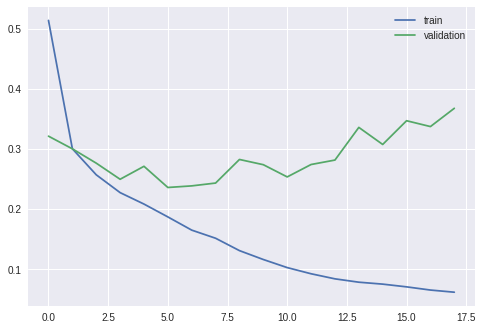

In [23]:
plt.plot(tr_hist, label = 'train')
plt.plot(val_hist, label = 'validation')
plt.legend()